### <b>Table of Content</b>

0. Import functions

1. Load data

2. 

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [54]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, add_moving_average, decompose_timeseries, normalize_scale

### <b>1. Load data</b>

In [55]:
# Details of the source file in G Drive
base_url = "https://drive.google.com/file/d/"
file_id = "1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk"
file_url = f"{base_url}{file_id}"
file_name = "2020Q1Q2Q3Q4-2021Q1.xlsx"

# Manually define sheet names as xlsx files have a 31-character limitation on sheet names.
full_sheet_names = [
    "Russia - Sberbank Rossii PAO (SBER)",
    "Turkey - Koc Holding AS (KCHOL)",
    "Egypt - Medinet Nasr Housing (MNHD)",
    "Brazil - Minerva SA/Brazil (BEEF3)",
    "Argentina - Pampa Energia SA (PAMP)",
    "Colombia - Cementos Argos SA (CCB)",
    "South Africa - Impala Platinum Holdings Ltd (IMPJ)",
    "South Korea - Dongkuk Steel Mill Co Ltd (001230)"
]

# Details of local directories
root_dir = sys.path[0]
download_dir = Path(root_dir) / "data"
file_path = download_dir / file_name

if os.path.exists(file_path):
    print(f"File {file_name} already exists in {download_dir}.")
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f"File {file_name} is not found in {download_dir}.")
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in c:\Users\Admin\Documents\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


### <b>2. Perform basic EDA</b>

In [56]:
data_dfs = load_dataframes(file_path, full_sheet_names)
print(f"{len(data_dfs)} DataFrames loaded with the following sheet names:\n")
for sheet_name in full_sheet_names:
    print(sheet_name)

print("\n\nBasic info of the first DateFrame:\n")
print(data_dfs[full_sheet_names[0]].info())

print("\n\nTail of the first DataFrame:")
data_dfs[full_sheet_names[0]].tail()

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Ta

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09,257.99,259.40,261.76,257.01,38.33M,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06,253.90,254.75,254.84,251.40,22.35M,-0.0043
310,2020-01-03,255.00,255.99,258.19,253.70,35.85M,0.0010


some description of the data set to be added.

### <b>3. Transform data types and split data into train and test sets</b>

Convert the Vol. column from string (object) to float so that it can be plotted and fed into a machine learning model.

Also, only select data from 2020 as training data and data from 2021 as test data.

In [57]:
train_dfs = {}
for name, df in data_dfs.items():
    df_copy = df.copy()
    df_copy['Vol.'] = df_copy['Vol.'].apply(convert_vol_to_float)
    train_df = df_copy[df_copy['Date'].dt.year == 2020]\
            .set_index('Date').sort_index()\
            .rename(columns={'Price': 'Close'})
    test_df = df_copy[df_copy['Date'].dt.year == 2021]\
            .set_index('Date').sort_index()\
            .rename(columns={'Price': 'Close'})
    train_dfs[name] = (train_df, test_df)

### <b>3. Add features and plot data</b>

In [58]:
stock_name_1 = full_sheet_names[0]
train_df_1, test_df_1 = train_dfs[stock_name_1]

- 3-1. add weekly/monthly/quarterly rolling average (or simple moving average; SMA), EMA (exponential MA)

One advantage of the EMA over SMA is that EMA is more responsive to price changes, which makes it useful for short-term trading.
    SMA assigns equal weights to all historical data points,
    EMA applies higher weights to recent prices

In [59]:
train_df_1 = add_moving_average(train_df_1)
test_df_1 = add_moving_average(test_df_1)

- 3-2. STL decomposition (Seasonal and Trend decomposition using Loess (locally estimated scatterplot smoothing?))

Plot seasonal componets of train_df_1:


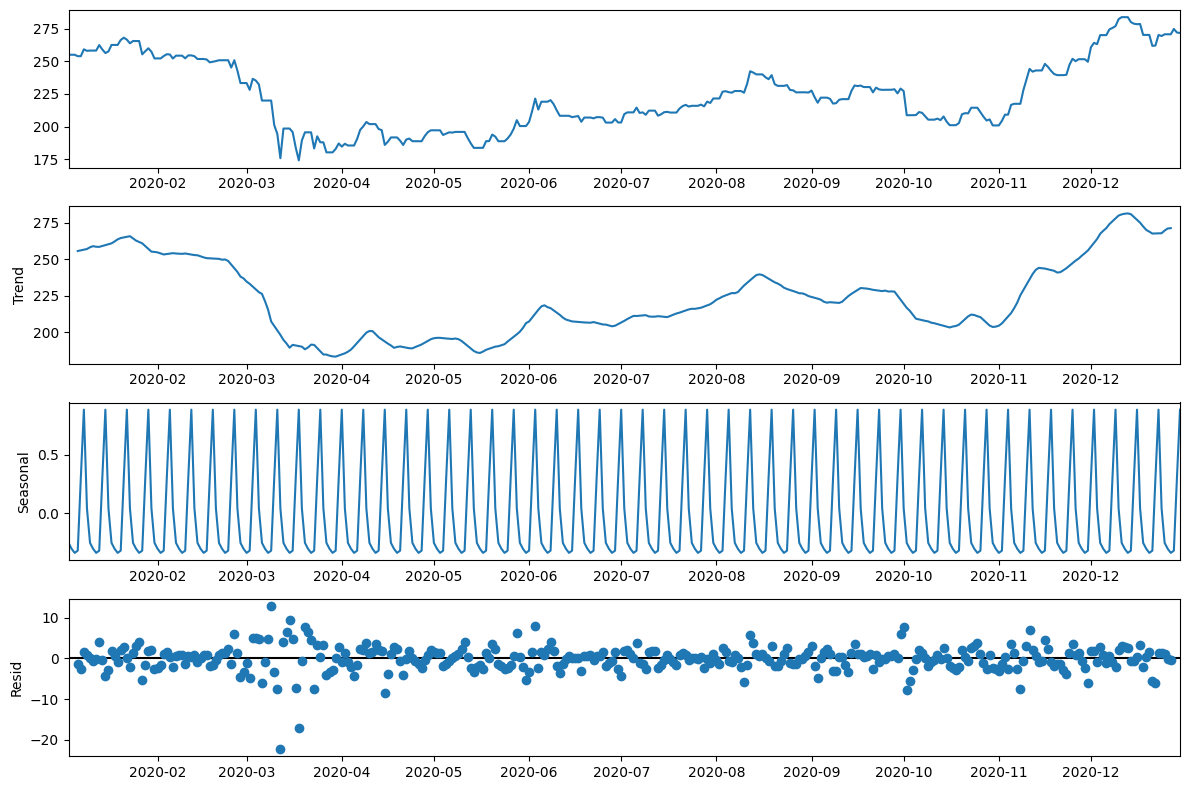

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

print("Plot seasonal componets of train_df_1:")
train_df_1 = decompose_timeseries(df=train_df_1, frequency='D', column='Close', add_to_df=True, plot=True)
test_df_1 = decompose_timeseries(df=test_df_1, frequency='D', column='Close', add_to_df=True, plot=False)

Through decomposition, we can see that the time series data is significantly dependent on seasonality.

- 3-3. PACF: the autocorrelation function

The PACF is an alternative to the ACF. Rather than giving the autocorrelations, it gives you the partial autocorrelation. This autocorrelation is called partial, because with each step back in the past, only additional autocorrelation is listed. This is different from the ACF, as the ACF contains duplicate correlations when variability can be explained by multiple points in time.

you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

In [61]:
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(train_df_1['Close'])

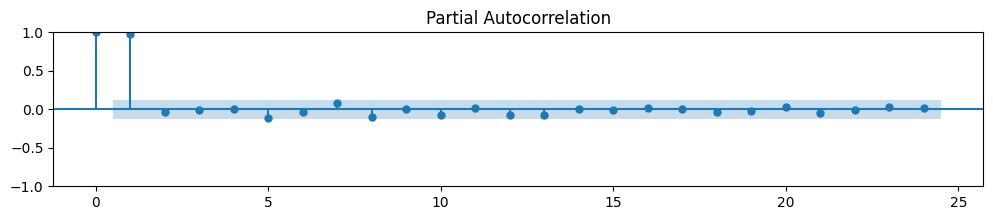

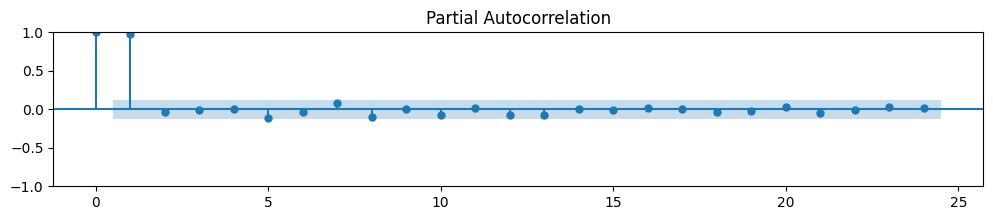

In [62]:
rcParams['figure.figsize'] = 12, 2
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df_1['Close'], method='ywm')

### * week number of the year, month, weekday, etc. can be added as separate columns too.
hypothesis: weekday will matter in prediction.
simple way to check: add the weekday column and compute the groupby average to see if each weekday is different from the other weekdays.

### <b>4. normalize scales</b>

* use the StandardScaler, rather than the MinMaxScaler,
The reason is that stock prices are ever-changing, and there are no true min or max values.
It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to
disastrous results at the end of the day;

In [63]:
normalized_train_df_1, normalized_test_df_1 = normalize_scale(train_df_1, test_df_1, method="standard", exclude_column='Close')
normalized_train_df_1

,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA,Trend,Seasonal,Residual
Date,,,,,,,,,,,,,,,
2020-01-03,255.00,1.198377,1.180675,1.212502,-0.940018,0.020361,NaN,NaN,NaN,1.209830,1.442283,1.713033,NaN,-0.883419,NaN
2020-01-06,253.90,1.151812,1.054281,1.126899,-1.269451,-0.208073,NaN,NaN,NaN,1.185268,1.416045,1.682007,1.248684,-1.036980,-0.438417
2020-01-08,259.15,1.107501,1.216895,1.187565,-0.818738,0.869443,NaN,NaN,NaN,1.266012,1.493548,1.771466,1.283935,1.740114,0.518910
2020-01-09,257.99,1.326428,1.315369,1.335695,-0.879500,-0.216693,NaN,NaN,NaN,1.288193,1.517458,1.799466,1.301560,-0.201610,0.283066
2020-01-10,258.19,1.268598,1.220668,1.330857,-1.354859,0.011741,NaN,NaN,NaN,1.303364,1.533862,1.818592,1.348524,-0.883419,0.063590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,269.32,1.798828,1.732657,1.712347,-0.775058,-0.147732,1.820316,2.157332,1.967955,1.783551,1.697671,0.869956,1.719596,-0.201610,0.442502
2020-12-25,270.64,1.723349,1.663989,1.755149,-1.522260,0.188453,1.777480,2.203835,2.003241,1.792902,1.727779,0.907419,1.790926,-0.883419,0.372852
2020-12-28,274.70,1.758272,1.822076,1.809115,-0.862175,0.623770,1.756368,2.248758,2.050930,1.839575,1.768037,0.949007,NaN,-1.036980,NaN


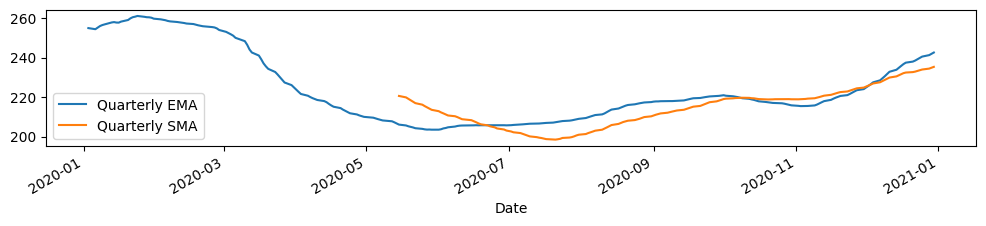

In [64]:
import matplotlib.pyplot as plt

train_df_1['Quarterly EMA'].plot(label='Quarterly EMA')
train_df_1['Quarterly SMA'].plot(label='Quarterly SMA')
plt.legend();

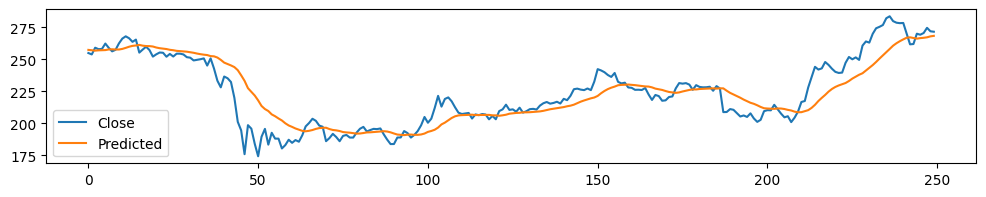

In [65]:
from statsmodels.tsa.api import SimpleExpSmoothing

es = SimpleExpSmoothing(train_df_1.Close.values)
es.fit(smoothing_level=0.1)

plt.plot(train_df_1.Close.values, label='Close')
plt.plot(es.predict(es.params, start=0, end=None), label='Predicted')
plt.legend();

### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

In [66]:
normalized_train_df_1.describe()

,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA,Trend,Seasonal,Residual
count,250.000000,2.500000e+02,2.500000e+02,2.500000e+02,250.000000,2.500000e+02,2.440000e+02,2.210000e+02,1.600000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.460000e+02,2.500000e+02,2.460000e+02
mean,224.216280,-2.842171e-17,1.122658e-15,1.705303e-16,0.000000,-2.131628e-17,1.747236e-16,1.253899e-15,-1.554312e-16,4.973799e-16,-5.115908e-16,2.273737e-15,-5.487932e-16,-2.664535e-18,7.220963e-18
std,26.778554,1.002006e+00,1.002006e+00,1.002006e+00,1.002006,1.002006e+00,1.002056e+00,1.002270e+00,1.003140e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002039e+00,1.002006e+00,1.002039e+00
min,174.270000,-1.842935e+00,-1.686389e+00,-1.822672e+00,-1.522260,-4.147471e+00,-1.481173e+00,-1.466743e+00,-1.646413e+00,-1.484374e+00,-1.442682e+00,-1.158744e+00,-1.551809e+00,-1.036980e+00,-6.814241e+00
25%,203.790000,-7.644503e-01,-7.795605e-01,-7.446363e-01,-0.687759,-4.580563e-01,-6.786079e-01,-7.548754e-01,-8.062869e-01,-6.950752e-01,-8.445118e-01,-8.044405e-01,-7.319138e-01,-8.834194e-01,-4.569990e-01
50%,220.145000,-1.568639e-01,-1.728705e-01,-1.642128e-01,-0.208069,-5.499641e-03,-1.445320e-01,-6.522494e-02,8.375928e-02,-1.299714e-01,-1.258661e-01,-3.393298e-01,-1.561760e-01,-2.016100e-01,8.697638e-02
75%,247.825000,8.930813e-01,8.577104e-01,8.459921e-01,0.388021,5.418784e-01,7.749575e-01,4.754287e-01,5.325338e-01,8.357387e-01,8.336402e-01,6.211810e-01,7.779803e-01,3.921471e-01,5.177492e-01
max,283.730000,2.288127e+00,2.295581e+00,2.183162e+00,4.603962,5.537242e+00,2.198452e+00,2.341664e+00,2.141993e+00,2.093425e+00,1.824321e+00,2.056014e+00,2.225260e+00,1.740114e+00,2.432579e+00


In [67]:
temp_train_df = normalized_train_df_1.asfreq('D').ffill().dropna(axis=1)
y_train_1 = temp_train_df.Close
X_train_1 = temp_train_df.drop('Close', axis=1)

temp_test_df = normalized_test_df_1.asfreq('D').ffill().dropna(axis=1)
y_test_1 = temp_test_df.Close
X_test_1 = temp_test_df.drop('Close', axis=1)

In [68]:
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train_1, 
                    exogenous= X_train_1,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
step_wise.summary()

# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2046.248, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2042.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2044.889, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2044.889, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2040.992, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.378 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1019.496
Date:                Thu, 08 Jun 2023   AIC                           2040.992
Time:                        21:08:07   BIC                           2044.884
Sample:                    01-03-2020   HQIC                          2042.539
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        16.3577      0.584     28.034      0.000      15.214      17.501
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               680.80
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  363
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -692.722
Date:                           Thu, 08 Jun 2023   AIC                           1413.445
Time:                                   21:08:10   BIC                           1467.966
Sample:                               01-03-2020   HQIC                          1435.117
                                    - 12-30-2020                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open             -2.1722      0.497     -4.372      0.000      -3.146      -1.198
High              3.9293      0.48

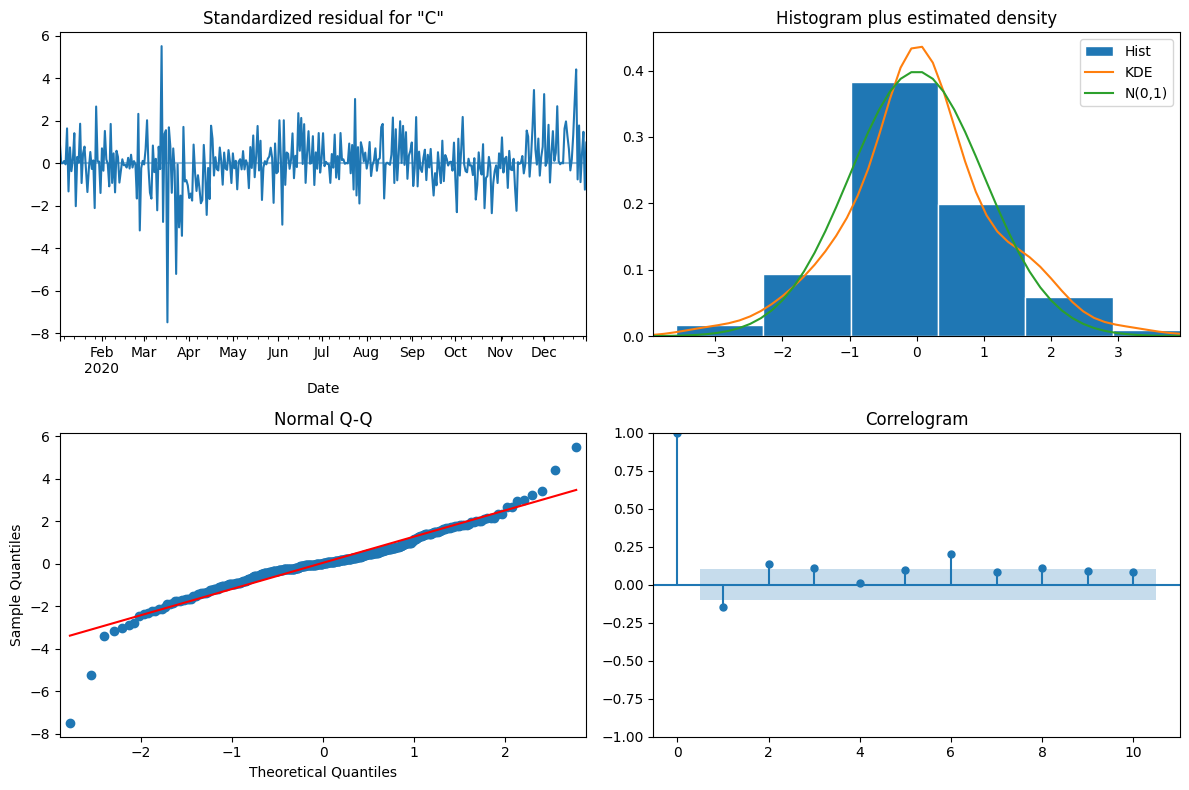

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train_1,
    exog = X_train_1,
    order=(1,0,1),
    seasonal_order=(1,0,1,7)
    )
results = sarimax_model.fit(disp=False)
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method above produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3. Normal Q-Q plot, with Normal reference line.
4. Correlogram

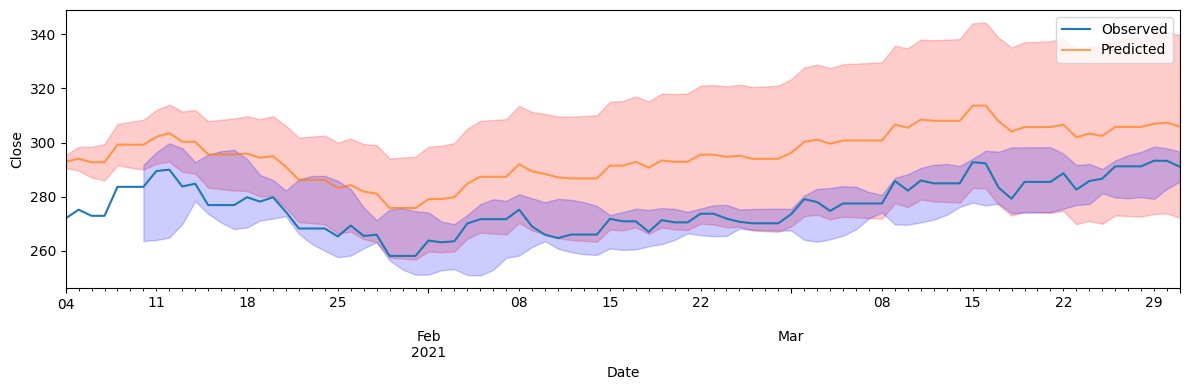

In [85]:
from datetime import timedelta

pred = results.get_prediction(start=X_train_1.shape[0],
                              end=X_train_1.shape[0] + X_test_1.shape[0] - 1,
                              exog=X_test_1)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

# Push the dates to 4 days later in the predictions since there's no trading data between Dec 31th and Jan 3nd.
pred_mean.index += timedelta(days=4)
pred_ci.index += timedelta(days=4)

ax = y_test_1.plot(label='Observed', figsize=(12, 4))
pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0], # lower band/confidence interval
                pred_ci.iloc[:, 1], # upper band/confidence interval
                color='r', alpha=.2)


time_period = 7
rolling_mean = y_test_1.rolling(window=time_period).mean()
rolling_std = y_test_1.rolling(window=time_period).std()

upper_band = rolling_mean + (rolling_std * 2.5)
lower_band = rolling_mean - (rolling_std * 2.5)

ax.fill_between(y_test_1.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()

if the predicted price is lower than the lowerbound—> buy?

if the predicted price is higher than the upperbound—> sell?

In [71]:
1 predict
2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)
3 decide to buy/hold/sell based on the threshold
4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

SyntaxError: invalid syntax (899459388.py, line 1)

SARIMAX is a powerful tool for modeling and forecasting time series data, especially when there are known seasonal patterns and the influence of exogenous variables needs to be considered.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous variables allows for the incorporation of additional factors that may influence the time series.

The SARIMAX model is typically denoted as SARIMAX(p, d, q)(P, D, Q, s), where:

p, d, and q are the orders of the non-seasonal AR, differencing, and MA components, respectively.
P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
Exogenous variables can be included in the model by specifying them separately.

The SARIMAX model assumes that the time series is stationary after differencing. It models the relationship between the observations and the lags of the observations (autoregressive terms), the differences between observations (differencing terms), and the errors (moving average terms), both in the non-seasonal and seasonal components.

p is the number of autoregressive terms
d is the number of non-seasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation

ARIMA. it just takes the past values of the stock market.

=> move on to SARIMA. S stands for seasonality.

=> SARIMAX - also takes into account external features (i.e, other features)
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

=> primarily they are used for understanding the patterns or features of the time series data but we can use them for predictions.

facebook's PROPHET. easy to understand. conceptually similar to SARIMAX.

Uber's timeseries prediction model.


https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


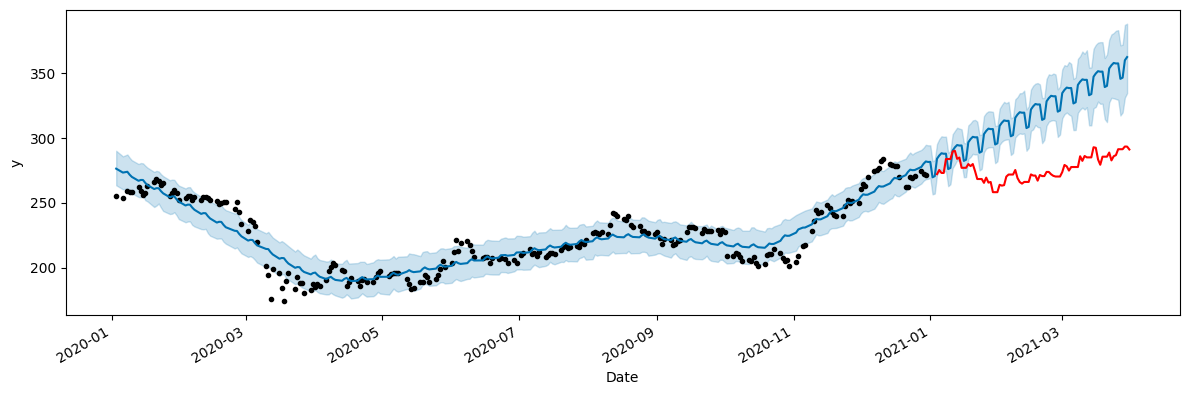

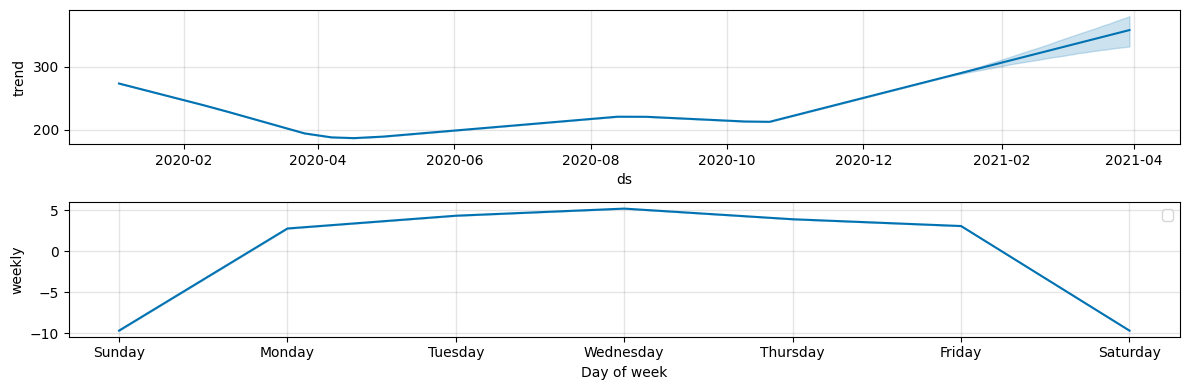

In [90]:
from prophet import Prophet
m = Prophet()
m.fit(normalized_train_df_1.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'}))

# Forecast for the next 3 months
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# print(forecast.tail())

m.plot(forecast, figsize=(12, 4))
y_test_1.plot(label='Close', color='red')
m.plot_components(forecast, figsize=(12, 4))
plt.legend();

3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.

* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
=> can be difficult/time-consuming to understand. can be tried out after trying simpler models.

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()
=> takes in only 1 column

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance
=> create bollinger bands using the prediced price and recommend buy, hold, or sell decisions?


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).
how to quantify or calculate the returns when we don't know how many stocks we had and when we bought them?


8. use bollinger bands to measure the system/model's effectiveness??

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Candlestick(
#     x=train_df_1.index,
#     open=train_df_1['Open'],
#     high=train_df_1['High'],
#     low=train_df_1['Low'],
#     close=train_df_1['Close']
#     )
#     ])

# # fig.update_layout(
# #     margin=dict(l=30, r=30, t=10, b=10),
# #     # paper_bgcolor="LightSteelBlue",
# # )

# fig.update_layout(
#     title=f"{stock_name_1}: Daily OHLC", 
#     yaxis_title="Price (USD)",
#     width=900,
#     height=600)

# fig.show()

In [ ]:
# # Candlestick Chart and Volume Separately
# # Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

# from plotly.subplots import make_subplots

# # figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # candlestick
# fig.add_trace(
#     go.Candlestick(
#         x=train_df_1.index,
#         open=train_df_1.Open,
#         high=train_df_1.High,
#         low=train_df_1.Low,
#         close=train_df_1.Close,
#         showlegend=False),
#     row=1,
#     col=1,
#     secondary_y=True
# )

# # volume
# fig.add_trace(
#     go.Bar(x=train_df_1.index,
#            y=train_df_1["Vol."],
#            showlegend=False,
#            marker={
#                "color": "grey",
#            }),
#     secondary_y=False,
# )

# fig.update_layout(title=f"{stock_name_1}: Daily OHLCV",
#                   yaxis_title="Price (USD)",
#                   width=900,
#                   height=600)

# fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.

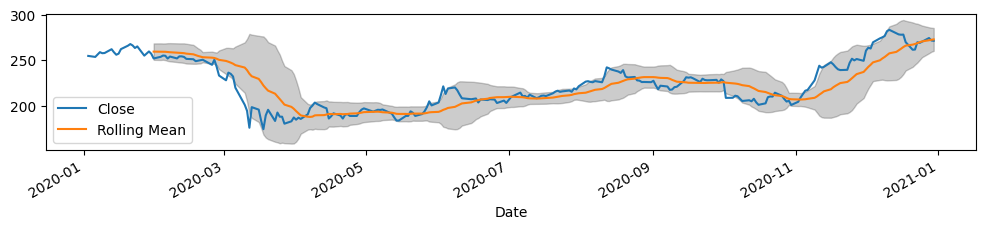

In [73]:
import matplotlib.pyplot as plt

# Define time period and calculate rolling mean and standard deviation
time_period = 20
rolling_mean = train_df_1['Close'].rolling(window=time_period).mean()
rolling_std = train_df_1['Close'].rolling(window=time_period).std()

# Calculate upper and lower Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Plot the data and the Bollinger Bands
ax = train_df_1['Close'].plot(label='Close')
plt.plot(rolling_mean, label='Rolling Mean')
ax.fill_between(
    rolling_mean.index,
    upper_band,
    lower_band,
    color='k', alpha=.2
)
# plt.plot(upper_band, label='Upper Bollinger Band')
# plt.plot(lower_band, label='Lower Bollinger Band')
plt.legend()
plt.show()